Challenger data analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from typing_extensions import Literal

Import dataset

In [2]:
orings = pd.read_csv('o-ring-erosion-only.data', sep=' ', 
                     header=None, index_col=-1,
                     names=['total', 'eroded', 'temperature', 'pressure', ''])
orings.head()

,total,eroded,temperature,pressure
,,,,
1,6,0,66,50
2,6,1,70,50
3,6,0,69,50
4,6,0,68,50
5,6,0,67,50


Code for forming design matrix.

In [41]:
# compute number of entries
n = orings.shape[0]

# compute design matrix by first getting relevant colume and stacking a column of one
X = np.hstack([np.ones((n,1)), orings[["temperature", "pressure"]].to_numpy()])

# compute output vector
y = orings["eroded"].to_numpy()

Compute loss function

In [116]:
def loss(beta: np.ndarray, X: np.ndarray, y: np.ndarray) -> float:
    '''Compute value of the empirical loss.'''
    
    # compute vector of np.dot(xi, beta)
    theta = X @ beta  

    # compute vector of summands
    ell_vec = y * theta - 6 * np.log(1 + np.exp(theta))

    return np.sum(ell_vec)

Compute score vector.

In [178]:
def score(beta: np.ndarray, X: np.ndarray, y: np.ndarray) -> np.ndarray:
    '''Compute the accurate score vector.'''
    
    theta = X @ beta
    return X.T @ (y - 6 / (1 + np.exp(-theta)))

Compute a sample of score vector.

In [179]:
def score_sample(beta: np.ndarray, X: np.ndarray, y: np.ndarray, 
                 rng_generator: np.random.Generator=None) -> np.ndarray:

    if rng_generator:
        x_i = X[rng_generator.integers(n)]
        y_i = y[rng_generator.integers(n)]
    else:
        x_i = X[np.random.randint(n)]
        y_i = y[np.random.randint(n)]

    return n * (y_i - 6 / (1 + np.exp(-np.dot(x_i, beta)))) * x_i


(Stochastic) gradient descent

In [291]:
def sgd(X: np.ndarray, y: np.ndarray, beta: np.ndarray=np.zeros(3), stochastic: bool=False,
        step_schedule: Literal["constant", "robbins"]="constant", alpha: float=1.,
        max_step: int=25, tol: float=1e-10, 
        rng_generator: np.random.Generator=None, 
        store_history: bool=False) -> np.ndarray:

    if store_history:
        history = [beta]   # create list of history of beta

    # SGD
    for k in range(max_step):

        # sample score vector
        if stochastic:
            update = score_sample(beta, X, y, rng_generator)
        else:
            update = score(beta, X, y)

        # update beta
        if step_schedule == "robbins":
            new_beta = beta + alpha / (k + 1) * update
        else:
            new_beta = beta + alpha * update

        # store history
        if store_history:
            history.append(new_beta)
        
        # check if terminate
        if abs(loss(new_beta, X, y) - loss(beta, X, y)) < tol:
            break
        else:
            beta = new_beta

    # return
    if store_history:
        return history
    else:
        return new_beta

IWLS

In [287]:
def IWLS(X: np.ndarray, y: np.ndarray, beta: np.ndarray=np.zeros(3), 
         step_schedule: Literal["constant", "robbins"]="constant", alpha: float=1.,
         max_step: int=25, tol: float=1e-10, 
         store_history: bool=False) -> np.ndarray:
    '''Perform iterated weighted least square on the dataset, depends on stepsize alpha.'''

    if store_history:
        history = [beta]   # create list of history of beta

    # IWLS
    for k in range(max_step):

        if step_schedule == "robbins":
            alpha_k = alpha / (1 + k)
        else:
            alpha_k = alpha

        # compute weights vector
        logistic = 1 / (1 + np.exp(-X @ beta))
        weights = 6 * logistic * (1 - logistic)

        # TODO: check if the alpha_k scalings are correct
        # compute target for regression
        y_tilde = y / weights
        mu_tilde = 1 / (1 - logistic)
        big_y = (alpha_k ** (1/4)) * np.sqrt(weights) * (y_tilde - mu_tilde + X @ beta / alpha_k)
        
        # compute design matrix for regression
        new_design = (alpha_k ** (1/4)) * np.sqrt(weights).reshape(-1,1) * X

        # update beta
        new_beta = np.linalg.lstsq(new_design, big_y, rcond=None)[0]

        # store history
        if store_history:
            history.append(new_beta)

        # check if terminate
        if abs(loss(new_beta, X, y) - loss(beta, X, y)) < tol:
            break
        else:
            beta = new_beta

    # return
    if store_history:
        return history
    else:
        return new_beta

Text(0, 0.5, 'likelihood')

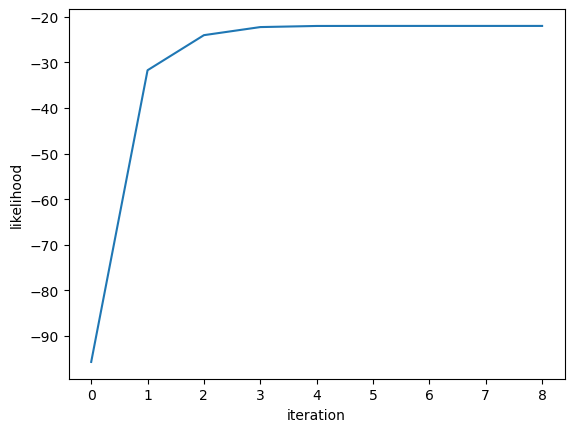

In [295]:
hist_IWLS = IWLS(X, y, alpha=1, max_step=50, store_history=True)
plt.plot([loss(beta, X, y) for beta in hist_IWLS])
plt.xlabel("iteration")
plt.ylabel("likelihood")

In [289]:
hist_IWLS

[array([0., 0., 0.]),
 array([ 0.69680184, -0.03883155,  0.00136306]),
 array([ 3.08605881e+00, -8.83144736e-02,  2.73997383e-03]),
 array([ 5.70547497e+00, -1.35827097e-01,  3.30005794e-03]),
 array([ 7.30792111e+00, -1.62639841e-01,  2.90973044e-03]),
 array([ 7.74756342e+00, -1.69383632e-01,  2.60891731e-03]),
 array([ 7.77207302e+00, -1.69734718e-01,  2.58466621e-03]),
 array([ 7.77213793e+00, -1.69735619e-01,  2.58459327e-03]),
 array([ 7.77213793e+00, -1.69735619e-01,  2.58459327e-03])]

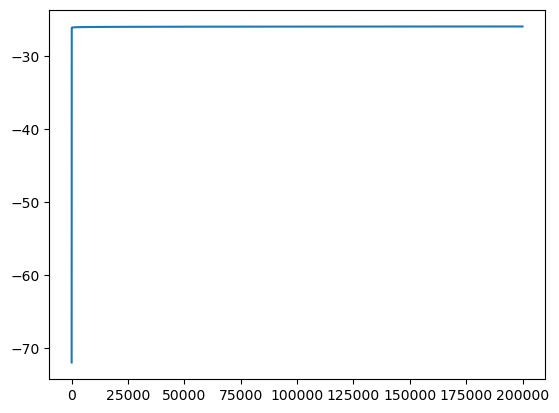

In [292]:
hist_sgd = sgd(X, y, beta=np.array([0.,-1.69735619e-01,0.]), alpha=1e-5, step_schedule="robbins", store_history=True, max_step=200000)
plt.plot([loss(beta, X, y) for beta in hist_sgd])

In [251]:
hist_sgd[-1]

array([ 0.00077412, -0.078453  ,  0.01322627])

In [153]:
endog = pd.DataFrame()
endog["eroded"] = orings["eroded"]
endog["normal"] = 6 - orings["eroded"]

exog = sm.add_constant(orings[["temperature", "pressure"]], prepend=False)

In [221]:
glm_binom = sm.GLM(endog, exog, family=sm.families.Binomial())
res = glm_binom.fit()
print(res.params)

temperature   -0.169736
pressure       0.002585
const          7.772138
dtype: float64


Plot loss surface

In [47]:
def loss_alt(beta0: float | np.ndarray, beta1: float | np.ndarray, 
             beta2: float | np.ndarray, X: np.ndarray, y: np.ndarray) -> float:
    '''Compute value of the empirical loss.'''

    # compute vector of np.dot(xi, beta)
    theta = np.stack([beta0] * n, axis=2) * X.T[0] + np.stack([beta1] * n, axis=2) * X.T[1] + np.stack([beta2] * n, axis=2) * X.T[2] 

    # compute vector of summands
    ell_individual = theta * y - 6 * np.log(1 + np.exp(theta))

    return np.sum(ell_individual, axis=2)

In [136]:
x_grid = np.linspace(-1,10,500)
y_grid = np.linspace(-0.01,0.01,500)

xv, yv = np.meshgrid(x_grid, y_grid)
loss_surface_02 = loss_alt(xv, -0.169736 * np.ones(xv.shape), yv, X, y)

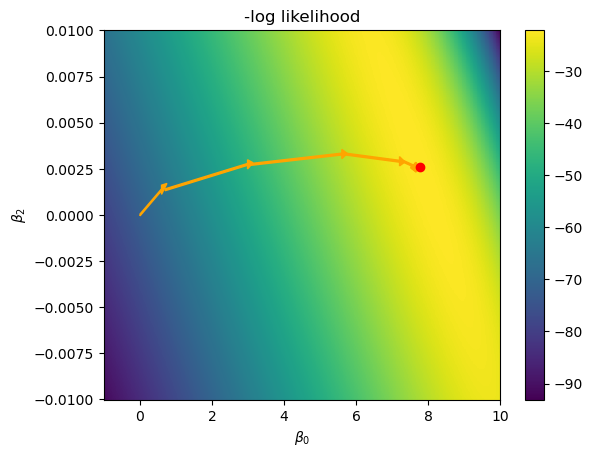

In [296]:
fig, ax = plt.subplots()
im = ax.pcolormesh(x_grid, y_grid, loss_surface_02)

for i in range(len(hist_IWLS) - 1):
    diff = hist_IWLS[i+1] - hist_IWLS[i]
    ax.arrow(hist_IWLS[i][0], hist_IWLS[i][2], diff[0] - .1, diff[2], length_includes_head=False,
             color="orange", width=.0001, head_width=.0005, head_length=.15)

ax.scatter([7.77213793e+00], [2.58459327e-03], color="red")
ax.set_title("-log likelihood")
ax.set_xlabel(r"$\beta_0$")
ax.set_ylabel(r"$\beta_2$")
fig.colorbar(im, ax=ax)

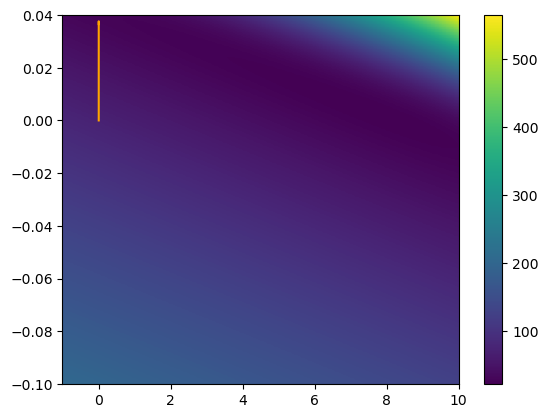

In [294]:
x_grid_new = np.linspace(-1,10,500)
y_grid_new = np.linspace(-0.1,0.04,500)

xv_new, yv_new = np.meshgrid(x_grid_new, y_grid_new)
loss_surface_02_new = loss_alt(xv_new, -0.169736 * np.ones(xv_new.shape), yv_new, X, y)

fig, ax = plt.subplots()
im = ax.pcolormesh(x_grid_new, y_grid_new, -loss_surface_02_new)

hist_sgd_arr = np.array(hist_sgd)
plt.plot(hist_sgd_arr[:,0], hist_sgd_arr[:,2], color="orange")
fig.colorbar(im, ax=ax)

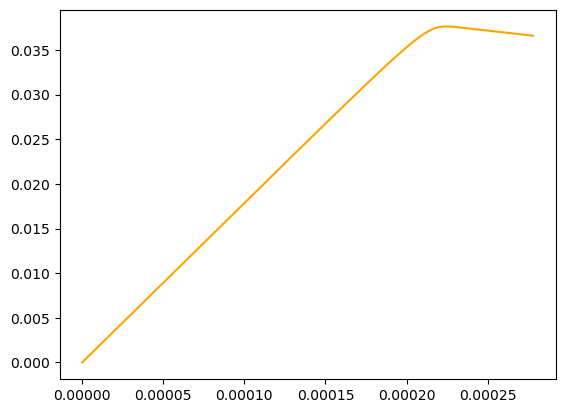

In [293]:
hist_sgd_arr = np.array(hist_sgd)
plt.plot(hist_sgd_arr[:,0], hist_sgd_arr[:,2], color="orange")